# **Analyse in Pandas en PowerBI**
Groep 8

***Airport iata codes*** <br>
**FR** = Ryanair <br>
**SN** = Brussels Airlines <br>
**HV** = Transavia <br>
**TB** = Tui

In [10]:
import os
import csv
import sys
import warnings
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

warnings.filterwarnings('ignore')

In [11]:
folder = 'C:\\ProgramData\\MySQL\\MySQL Server 8.0\\Uploads\\'
files = os.listdir(folder)

In [12]:
# create new dataframe
allData = pd.DataFrame()

# loop through files and append to dataframe
for i, file in enumerate(files):
    filepath = os.path.join(folder, file)
    df = pd.read_csv(filepath, skiprows=0)
    allData = allData.append(df, ignore_index=True)

# save to csv
allData.to_csv('../analyse/allData.csv', index=False)

## 1) Welke vliegtuigmaatschappij is gemiddeld de goedkoopste / de duurste?

Kan zowel in Python als in PowerBI

De goedkoopste vliegtuigmaatschappij is FR met een gemiddelde prijs van 113.3 euro.
De duurste vliegtuigmaatschappij is TB met een gemiddelde prijs van 201.37 euro.


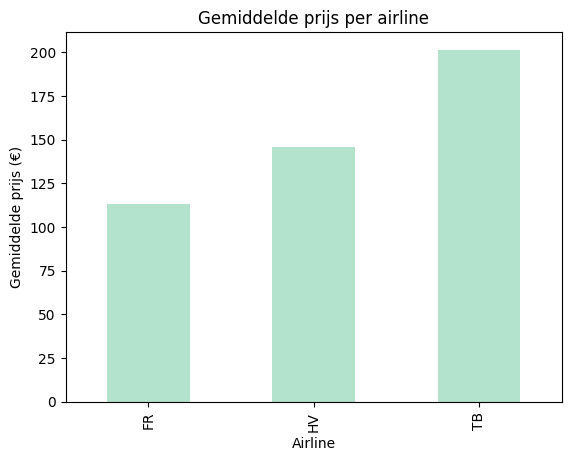

In [13]:
# read the data
data = pd.read_csv('../analyse/allData.csv')

# group the data by airline and calculate the average price
grouped_data = data.groupby(['airline_iata_code'])['price'].mean()
sorted_data = grouped_data.sort_values()

# print the results
print("De goedkoopste vliegtuigmaatschappij is " + sorted_data.index[0] + " met een gemiddelde prijs van", round(sorted_data[0], 2), "euro.")
print("De duurste vliegtuigmaatschappij is " + sorted_data.index[-1] + " met een gemiddelde prijs van", round(sorted_data[-1], 2), "euro.")

# plot the results
grouped_data.plot(kind='bar', colormap='Pastel2')
plt.title('Gemiddelde prijs per airline')
plt.xlabel('Airline')
plt.ylabel('Gemiddelde prijs (€)')
plt.show()

## 2) Hoe vaak vliegt elke vliegtuigmaatschappij per week naar elk van de bestemmingen?

Kan zowel in Python als in PowerBI

In [14]:
# read the data
data = pd.read_csv('../analyse/allData.csv')

# add new column for weekday
data['weekday'] = pd.to_datetime(data['departure_date']).dt.day_name()

# group the data by airline and destination + count the number of flights per week
grouped_data = data.groupby(['airline_iata_code', 'arrival_airport_iata_code', 'weekday']).size().reset_index(name='countOfFlights')

pivoted_data = pd.pivot_table(grouped_data, values='countOfFlights', index=['airline_iata_code'], columns=['arrival_airport_iata_code', 'weekday'], fill_value=0)

sorted_data = pivoted_data.sort_values(by=['airline_iata_code'])

pd.DataFrame(sorted_data)

for i in range(len(sorted_data)):
    print("De vliegtuigmaatschappij " + sorted_data.index[i] + " heeft", sorted_data.iloc[i].sum(), "in totaal.")

De vliegtuigmaatschappij FR heeft 46742 in totaal.
De vliegtuigmaatschappij HV heeft 12642 in totaal.
De vliegtuigmaatschappij TB heeft 65692 in totaal.


In [15]:
# read the data
data = pd.read_csv('../analyse/allData.csv')

# open the file
with open('../analyse/allData.csv', 'r') as csv_file:
    reader = csv.DictReader(csv_file)
    flights = list(reader)

# create dictionary to hold count of flights per airline and destination
flights_count = {}

# iterate over flights and update count in dictionary
for flight in flights:
    airline = flight['airline_iata_code']
    destination = flight['arrival_airport_iata_code']
    if airline not in flights_count:
        flights_count[airline] = {}
    if destination not in flights_count[airline]:
        flights_count[airline][destination] = 0
    flights_count[airline][destination] += 1

# create list of airlines and destinations
airlines = list(flights_count.keys())
destinations = list(set(dest for dests in flights_count.values() for dest in dests.keys()))

# print table header
print('Airline'.ljust(15), end='')
for dest in destinations:
    print(dest.rjust(10), end='')
print('')

# print table body
for airline in airlines:
    print(airline.ljust(15), end='')
    for dest in destinations:
        count = flights_count.get(airline, {}).get(dest, 0)
        print(str(count).rjust(10), end='')
    print('')

Airline               IBZ       PMI       FAO       HER       TFS       PMO       AGP       RHO       ALC       NAP       BDS       CFU
FR                   2304      5072      6101      1179      2340      2903      7606      1751      7597      5251      2738      1900
HV                   2303         0      2977      1363       678         0      1994         0      3327         0         0         0
TB                   4747      7855      1318      6274      9663      1072     12608      5158     12676      1072      1025      2224


In [16]:
# read the data
data = pd.read_csv('../analyse/allData.csv')

# open new csv file
with open('../analyse/vluchtenPerWeek.csv', 'w', newline='') as csv_file:
    writer = csv.writer(csv_file)
    writer.writerow(['airline_iata_code', 'arrival_airport_iata_code', 'weekNr', 'countOfFlights'])

# open the allData.csv file
with open('../analyse/allData.csv', 'r') as file:
    reader = csv.DictReader(file)

    # initialize dictionary to store flights per airline per destination per week
    flights_per_week = {}

    # loop through the rows
    for row in reader:
        airline = row['airline_iata_code']
        destination = row['arrival_airport_iata_code']
        departure_date = row['departure_date']

        # convert departure date to datetime object
        departure_date_obj = datetime.datetime.strptime(departure_date, '%Y-%m-%d')

        # extract week number
        week_number = departure_date_obj.strftime('%W')

        # add to flights_per_week dictionary
        if airline not in flights_per_week:
            flights_per_week[airline] = {}
        if destination not in flights_per_week[airline]:
            flights_per_week[airline][destination] = {}
        if week_number not in flights_per_week[airline][destination]:
            flights_per_week[airline][destination][week_number] = 0
        flights_per_week[airline][destination][week_number] += 1

    with open('../analyse/vluchtenPerWeek.csv', 'a', newline='') as csv_file:
        # create csv writer
        writer = csv.writer(csv_file)

        # print flights per airline per destination per week
        for airline, destinations in flights_per_week.items():
            for destination, weeks in destinations.items():
                for week, num_flights in weeks.items():
                    # print(f"Airline: {airline}, Destination: {destination}, Week: {week}, Flights: {num_flights}")
                    writer.writerow([airline, destination, week, num_flights])

## 3) Welke vliegtuigmaatschappij biedt de snelste vlucht aan naar een bepaalde bestemming?

Volgens mij in PowerBI

## 4) Welke vliegtuigmaatschappij biedt de goedkoopste vlucht aan naar een bepaalde bestemming?

Volgens mij in PowerBI

## 5) Welke vliegtuigmaatschappij biedt een vlucht aan zonder tussenstops, met maximum 1 tussentop, ... ?

Volgens mij in PowerBI

## 6) Rapport over prijsevolutie en beschibaarheidsevolutie doorheen de tijd?

Geen idee wat ze hiermee bedoelen

## 7) Is er een correlatie met de vakantiebestemmingen: zijn bepaalde bestemmingen significant duurder dan andere bestemmingen?

Kan in zowel python als PowerBI denk ik?

## 8) Zijn de prijzen gerelateerd aan vakantieperiodes hier of ter plaatse?

Volgens mij in PowerBI

## 9) Kan je de prijsstrategie afleiden? (Invloed van aantal dagen voor vertrek, invloed van beschikbaarheid)

Weet ik niet in Python of PowerBI

## 10) Is er een link tussen prijs en afstand (en duration)? Bijvoorbeeld Tenerife is anderhalf uur verder dan Alicante.

Geen idee wat er hier moet gebeuren dus ook geen idee van Python of PowerBI

## 11) Is er een link tussen prijs en land? Zijn sommige landen opvallend duurder (en kan dit niet verklaard worden door de extra afstand)

Geen idee wat er hier moet gebeuren dus ook geen idee van Python of PowerBI

## 12) Hoeveel dagen voor vertrek is een vlucht volgeboekt? Zijn er bestemmingen waarbij de vluchten bijna volgeboekt zijn?

Kan in zowel Pyhton als PowerBI volgens mij

## 13) Hoeveel procent van de vluchten zijn volgeboekt? / Hoeveel plaatsen zijn er nog vrij 5 dagen voor vertrek.

In Python volgens mij

## 14) Plot het verband tussen de prijs en het aantal dagen voor vertrek voor Ryanair voor de afgelopen maand. Maak gebruik van regressie om de prijzen te voorspellen voor de volgende maand.

Plotten kan in zowel PowerBI als in Python, regressie is sowieso in Python

### Plot het verband tussen de prijs en het aantal dagen voor vertrek voor Ryanair voor de afgelopen maand.

Text(0, 0.5, 'Prijs (€)')

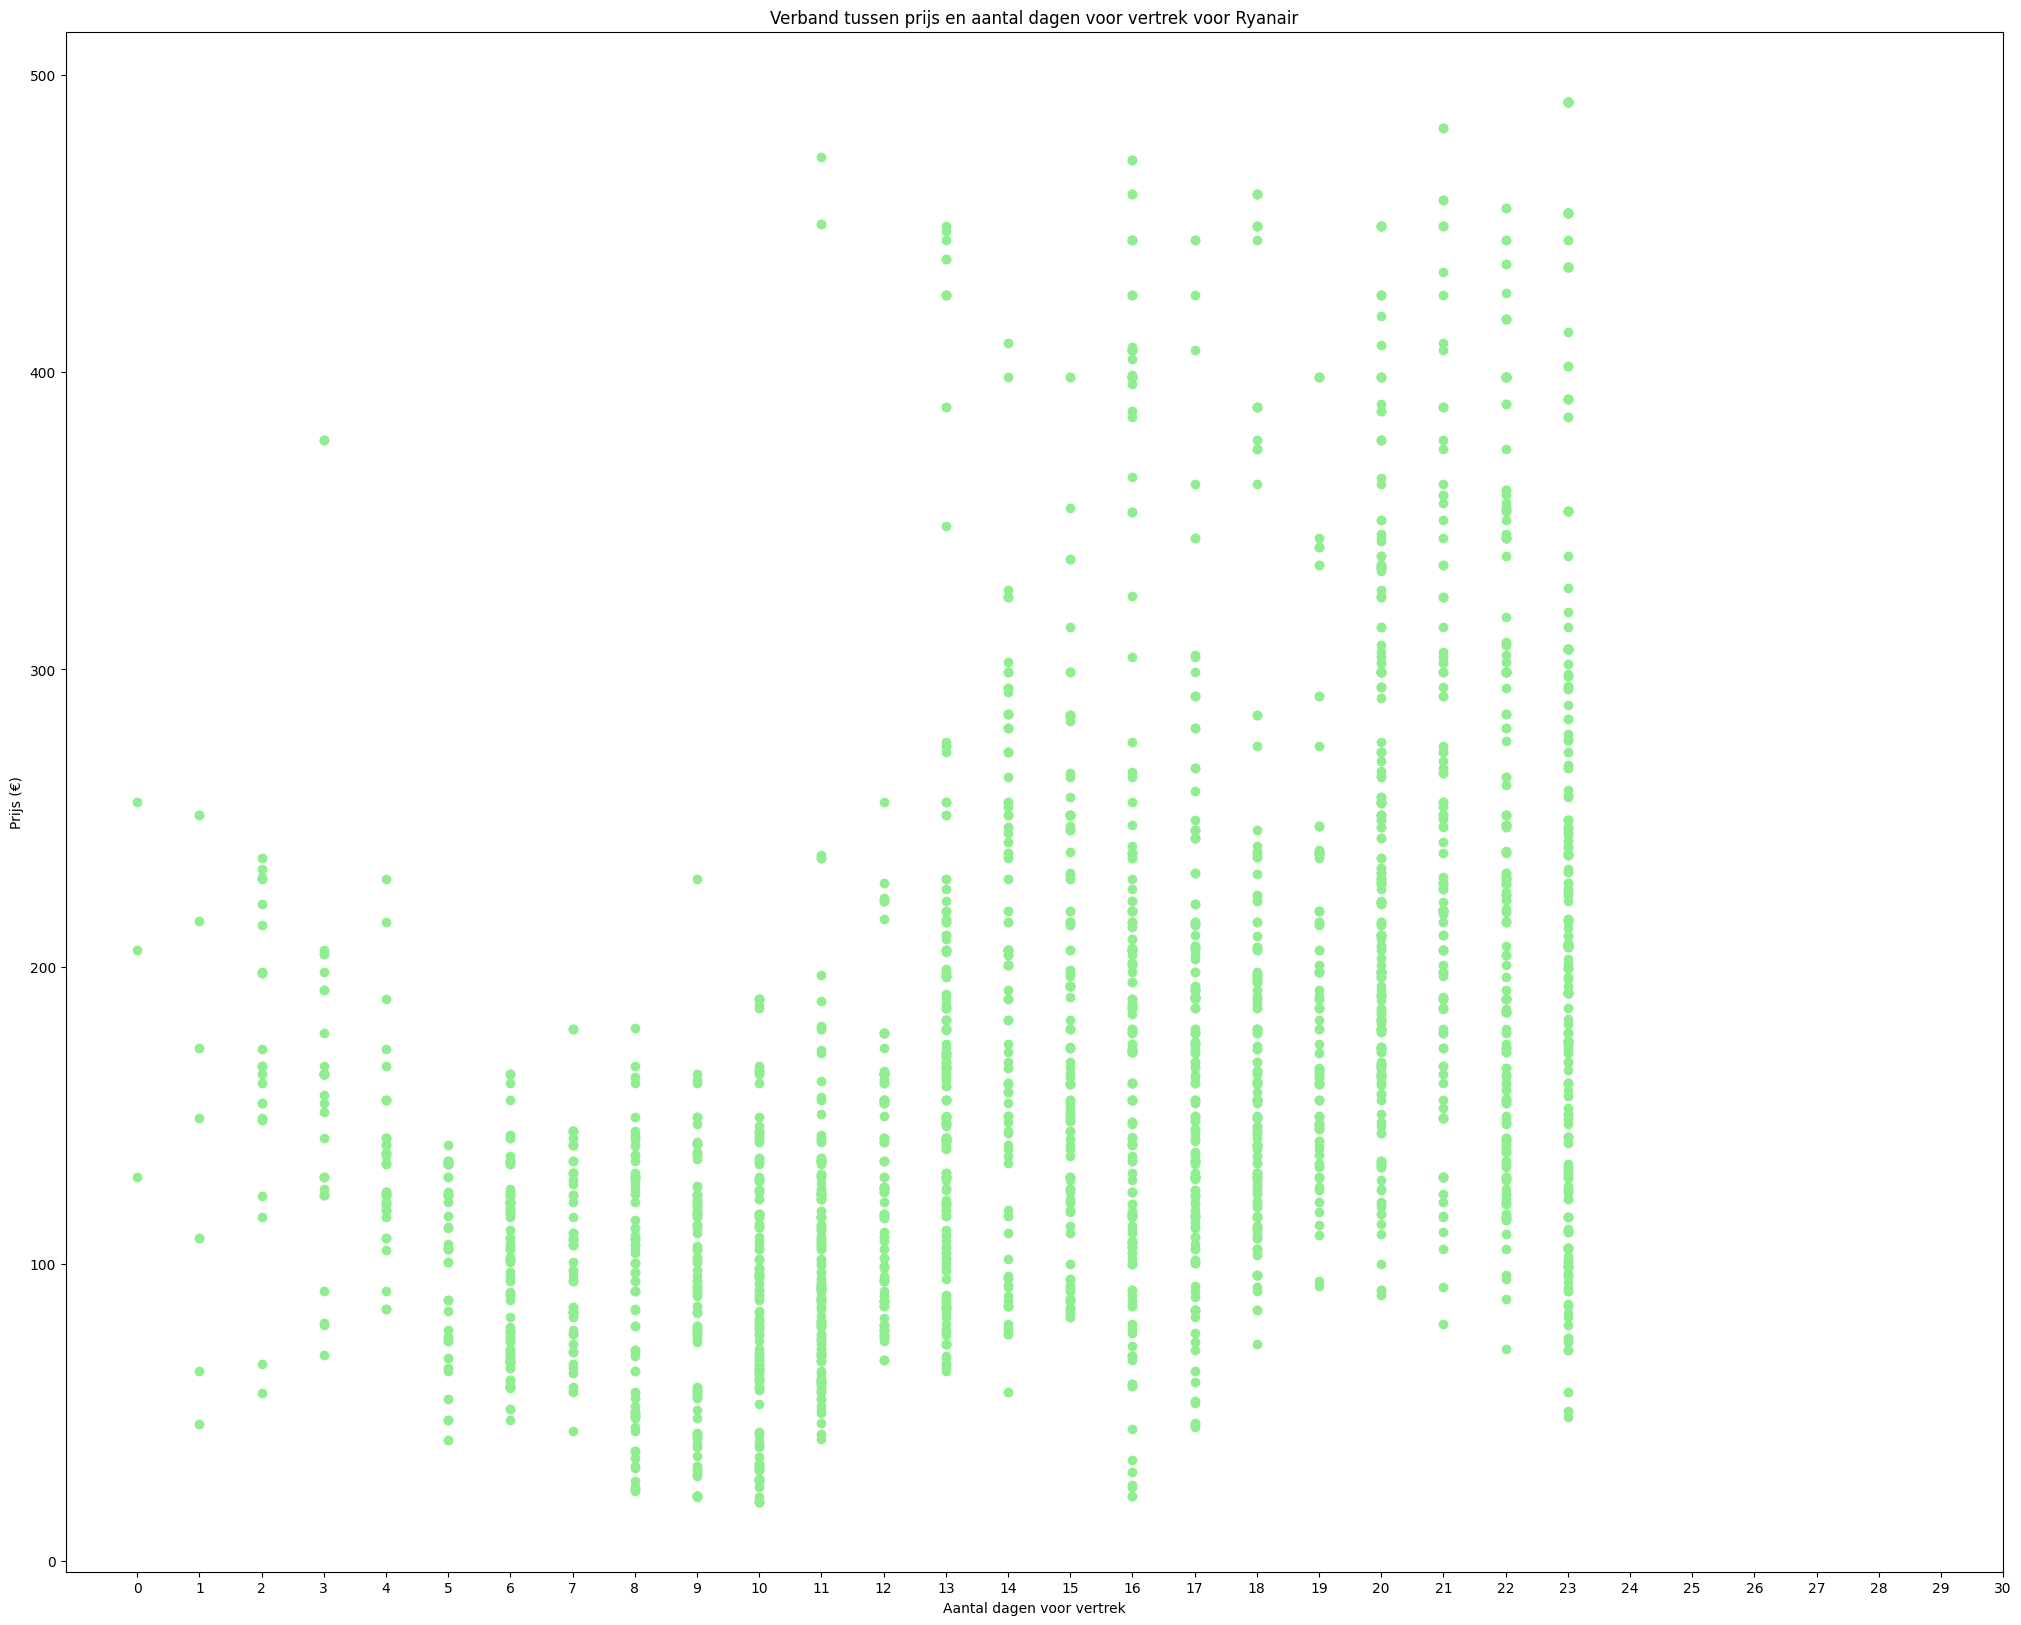

In [17]:
# read the data
data = pd.read_csv('../analyse/allData.csv')

# filter the data for Ryanair
data = data[data['airline_iata_code'] == 'FR']

# convert departure date to datetime object
data['departure_date'] = pd.to_datetime(data['departure_date'])

# add new column for days before departure
data['days_before_departure'] = (data['departure_date'] - data['departure_date'].min()).dt.days

# previous month with datetime
previous_month = datetime.datetime.now() - datetime.timedelta(days=30)

# today with datetime
today = datetime.datetime.now()

# filter the data for the last month ()
data = data[(data['departure_date'] >= previous_month) & (data['departure_date'] <= today)]

# plot the results
plt.figure(figsize=(25, 20))
plt.plot(data['days_before_departure'], data['price'], 'o', color='lightgreen')
plt.title('Verband tussen prijs en aantal dagen voor vertrek voor Ryanair')
plt.xticks(range(0, 31, 1))
plt.xlabel('Aantal dagen voor vertrek')
plt.ylabel('Prijs (€)')

### Maak gebruik van regressie om de prijzen te voorspellen voor de volgende maand.

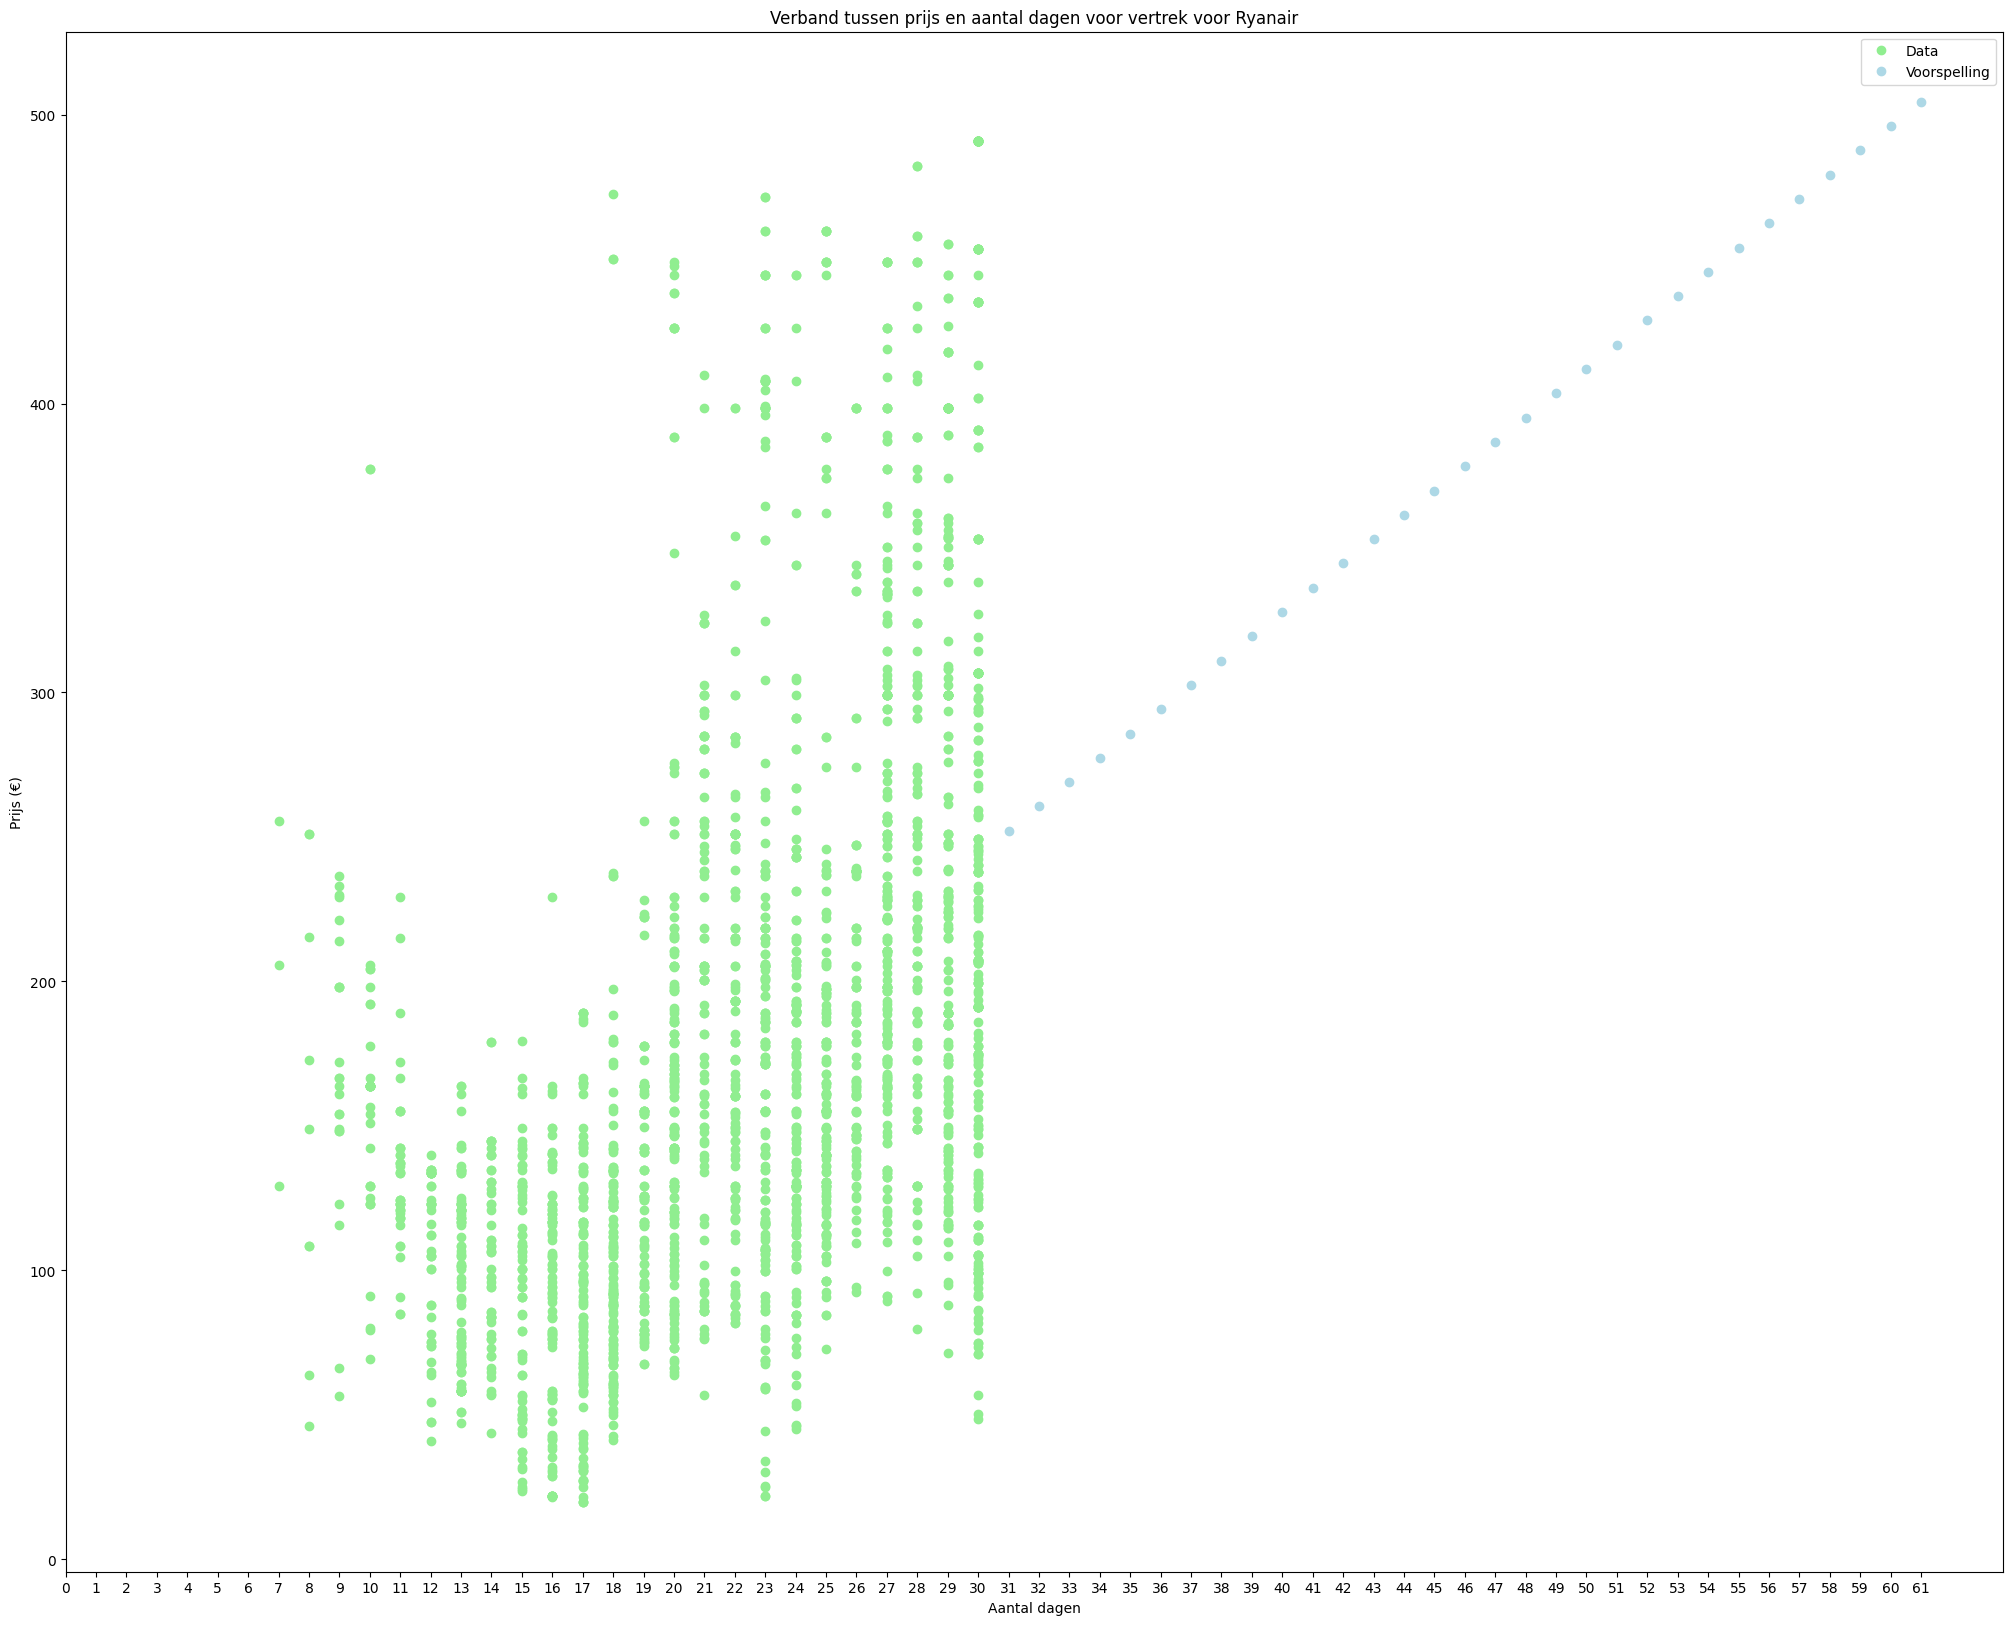

In [18]:
# read data for Ryanair only
data = pd.read_csv('../analyse/allData.csv', usecols=['airline_iata_code', 'departure_date', 'price'])
data = data[data['airline_iata_code'] == 'FR']

# convert departure date to datetime object
data['departure_date'] = pd.to_datetime(data['departure_date'])

# get date range for last month
today = datetime.date.today()
tomorrow = today + datetime.timedelta(days=1)
last_month = today - pd.DateOffset(months=1)
date_range = pd.date_range(start=last_month, end=today, freq='D')

# filter data for last month
data = data[data['departure_date'].isin(date_range)]

# create linear regression model
model = LinearRegression()

# fit the model
X_train = (data['departure_date'] - last_month).dt.days.values.reshape(-1, 1)
y_train = data['price'].values.reshape(-1, 1)
model.fit(X_train, y_train)

# predict prices for next month
next_month = today + pd.DateOffset(months=1)
next_month_range = pd.date_range(start=tomorrow, end=next_month, freq='D')
X_test = (next_month_range - last_month).days.values.reshape(-1, 1)
y_pred = model.predict(X_test)

# plot results
plt.figure(figsize=(25, 20))
plt.plot(X_train, y_train, 'o', color='lightgreen')
plt.plot(X_test, y_pred, 'o', color='lightblue')
plt.title('Verband tussen prijs en aantal dagen voor vertrek voor Ryanair')
plt.xticks(range(0, 62, 1))
plt.xlabel('Aantal dagen')
plt.ylabel('Prijs (€)')
plt.legend(['Data', 'Voorspelling'])
plt.show()

## 15) In PowerBI een kaart maken met de mogelijke bestemmingen als de prijs in een bepaalde range moet liggen (op een bepaald moment).

In PowerBI

Is volledig opgelost, blad noemt "15"